In [ ]:
import tensorflow as tf
import numpy as np
from NeuralFlow.flow import Flow_v2

2024-11-19 17:51:11.506500: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 17:51:11.558639: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def create_base_model(input_shape=1, output_shape=1):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)


In [ ]:
flow = Flow_v2(
    model_fn = create_base_model,
    n_models = 3,
    noise_stddev=1e-2, 
    lam = 1e-4)

In [ ]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


def optimizer_fn():
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.96)
    return tf.keras.optimizers.Adam(lr_scheduler)

flow.compile(optimizer_fn=optimizer_fn, loss_fn=loss_fn, metrics=['mae'])

In [ ]:
X_train = tf.cast(np.linspace(0, 1, 1000).reshape(-1, 1), tf.float32)
y_train = tf.cast(np.sin(X_train * 2 * np.pi).reshape(-1, 1), tf.float32)

batch_size = 32
loader_size = X_train.shape[0] // batch_size

In [ ]:
flow.fit(X_train, y_train, batch_size=batch_size, epochs=10)

Epoch 1/10


32/32 - 1s - 37ms/step - loss: 14336242.0000 - mae: 0.4637
Epoch 2/10
32/32 - 0s - 4ms/step - loss: 4529482.0000 - mae: 0.2388
Epoch 3/10
32/32 - 0s - 3ms/step - loss: 3186075.7500 - mae: 0.1636
Epoch 4/10
32/32 - 0s - 3ms/step - loss: 2778479.5000 - mae: 0.1282
Epoch 5/10
32/32 - 0s - 3ms/step - loss: 2694633.2500 - mae: 0.1222
Epoch 6/10
32/32 - 0s - 4ms/step - loss: 2667656.0000 - mae: 0.1264
Epoch 7/10
32/32 - 0s - 4ms/step - loss: 2617985.0000 - mae: 0.1266
Epoch 8/10
32/32 - 0s - 4ms/step - loss: 2549929.5000 - mae: 0.1229
Epoch 9/10
32/32 - 0s - 4ms/step - loss: 2460620.0000 - mae: 0.1207
Epoch 10/10
32/32 - 0s - 4ms/step - loss: 2391644.7500 - mae: 0.1325
Epoch 1/10
32/32 - 1s - 28ms/step - loss: 16180348.0000 - mae: 0.4957
Epoch 2/10
32/32 - 0s - 4ms/step - loss: 4975694.5000 - mae: 0.2595
Epoch 3/10
32/32 - 0s - 5ms/step - loss: 3177677.7500 - mae: 0.1639
Epoch 4/10
32/32 - 0s - 6ms/step - loss: 2771123.2500 - mae: 0.1290
Epoch 5/10
32/32 - 0s - 5ms/step - loss: 2679314.5000 

In [ ]:
est = flow.get_estimator("deep_ensemble")

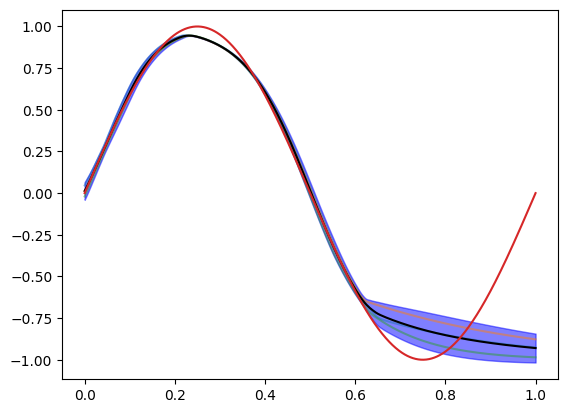

In [ ]:
import matplotlib.pyplot as plt

# print(est.logp, est.logq)
mean, var = est(X_train)
fig = plt.figure()

for model in flow.models:
    plt.plot(X_train, model(X_train), alpha=0.5)

plt.plot(X_train, mean.squeeze(), color='black')
plt.fill_between(tf.squeeze(X_train), mean.squeeze() - 1.96 * np.sqrt(var.squeeze()),  mean.squeeze() + 1.96 * np.sqrt(var.squeeze()), color='blue', alpha=0.5)


plt.plot(X_train, y_train)